In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.ensemble as skens
import sklearn.metrics as skmetric
import sklearn.naive_bayes as sknb
import sklearn.tree as sktree
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)
import sklearn.externals.six as sksix
import IPython.display as ipd
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import os
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Filter all warnings.
import warnings
warnings.filterwarnings('ignore')

In [4]:
ce_max = pd.read_csv('AD_CE_MAX.csv')
ce_max.head()

,SUBJECT_ID,HADM_ID,ADMISSIONTYPE,CHARTTIME,ITEMID,VALUE,VALUENUM
0,58526,100001,EMERGENCY,2117-09-15 17:57:00,226228,F,NaN
1,54610,100003,EMERGENCY,2150-04-19 14:13:00,226228,M,NaN
2,9895,100006,EMERGENCY,2108-04-11 14:00:00,128,Full Code,NaN
3,23018,100007,EMERGENCY,2145-04-04 12:00:00,27,Soft Distended,NaN
4,533,100009,EMERGENCY,2162-05-19 22:05:00,226228,M,NaN


In [2]:
diag = pd.read_csv("ad_diag.csv")

In [3]:
diag.head()

,SUBJECT_ID,HADM_ID,ADMISSIONTYPE,ICD9_CODE,SEQ_NUM
0,22,165315,EMERGENCY,9678,1.0
1,22,165315,EMERGENCY,9693,2.0
2,22,165315,EMERGENCY,E9502,3.0
3,22,165315,EMERGENCY,E9503,4.0
4,22,165315,EMERGENCY,3488,5.0


In [4]:
print(len(diag))

531010


In [5]:
diag['FIRST_ICD9_DIAGNOSIS'] = np.where(diag['SEQ_NUM'] == 1, diag['ICD9_CODE'], 0) 

In [6]:
diag['SECOND_ICD9_DIAGNOSIS'] = np.where(diag['SEQ_NUM'] == 2, diag['ICD9_CODE'], 0) 

In [7]:
diag['THIRD_ICD9_DIAGNOSIS'] = np.where(diag['SEQ_NUM'] == 3, diag['ICD9_CODE'], 0) 

In [8]:
diag['SEQ_NUM'].max()

39.0

someone has up to 39 assigned ICD9 diagnosis codes, but we're just going to focus on the top 3 for now.

In [9]:
diag_condense = diag[['SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'FIRST_ICD9_DIAGNOSIS', 'SECOND_ICD9_DIAGNOSIS', 'THIRD_ICD9_DIAGNOSIS']].copy()

In [10]:
diag_condense.head()

,SUBJECT_ID,HADM_ID,SEQ_NUM,FIRST_ICD9_DIAGNOSIS,SECOND_ICD9_DIAGNOSIS,THIRD_ICD9_DIAGNOSIS
0,22,165315,1.0,9678,0,0
1,22,165315,2.0,0,9693,0
2,22,165315,3.0,0,0,E9502
3,22,165315,4.0,0,0,0
4,22,165315,5.0,0,0,0


In [11]:
diag_c = diag_condense[(diag_condense['SEQ_NUM'] < 4)]
diag_c.head()

,SUBJECT_ID,HADM_ID,SEQ_NUM,FIRST_ICD9_DIAGNOSIS,SECOND_ICD9_DIAGNOSIS,THIRD_ICD9_DIAGNOSIS
0,22,165315,1.0,9678,0,0
1,22,165315,2.0,0,9693,0
2,22,165315,3.0,0,0,E9502
7,23,124321,1.0,2252,0,0
8,23,124321,2.0,0,3485,0


In [12]:
pat = pd.read_csv('AD_PAT.csv')
pat.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,ADMISSIONTYPE,DIAGNOSIS,GENDER
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,UNOBTAINABLE,MARRIED,WHITE,EMERGENCY,BENZODIAZEPINE OVERDOSE,F
1,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,ENGL,CATHOLIC,MARRIED,WHITE,EMERGENCY,BRAIN MASS,M
2,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,PROTESTANT QUAKER,SINGLE,WHITE,EMERGENCY,INTERIOR MYOCARDIAL INFARCTION,M
3,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,UNOBTAINABLE,MARRIED,WHITE,EMERGENCY,ACUTE CORONARY SYNDROME,M
4,26,197661,2126-05-06 15:16:00,2126-05-13 15:00:00,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,EMERGENCY,V-TACH,M


In [13]:
# look closer at DIAGNOSIS column
len(pat.DIAGNOSIS.unique()) #12202
len(pat) #43407
# i think it would be fine to replace these with number codes?? unsure... also depends how 'similar' things are
# but, there are repeats..
# maybe could split the column on words, make a matrix, and devise a system to code for word combinations?

43407

In [14]:
# change ADMITTIME and DISCHTIME to datetime objects to make 
# a new column for length of stay
pat['ADMITTIME'] = pd.to_datetime(pat['ADMITTIME'])
pat['DISCHTIME'] = pd.to_datetime(pat['DISCHTIME'])


In [15]:
pat['LENGTHOFSTAY'] = pat['DISCHTIME'] - pat['ADMITTIME']
pat.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,ADMISSIONTYPE,DIAGNOSIS,GENDER,LENGTHOFSTAY
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,UNOBTAINABLE,MARRIED,WHITE,EMERGENCY,BENZODIAZEPINE OVERDOSE,F,1 days 03:28:00
1,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,ENGL,CATHOLIC,MARRIED,WHITE,EMERGENCY,BRAIN MASS,M,6 days 18:26:00
2,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,PROTESTANT QUAKER,SINGLE,WHITE,EMERGENCY,INTERIOR MYOCARDIAL INFARCTION,M,2 days 20:34:00
3,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,UNOBTAINABLE,MARRIED,WHITE,EMERGENCY,ACUTE CORONARY SYNDROME,M,3 days 12:49:00
4,26,197661,2126-05-06 15:16:00,2126-05-13 15:00:00,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,EMERGENCY,V-TACH,M,6 days 23:44:00


In [16]:
pat['LENGTHOFSTAY_DAYS'] = [d.days for d in pat['LENGTHOFSTAY']]
pat.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,ADMISSIONTYPE,DIAGNOSIS,GENDER,LENGTHOFSTAY,LENGTHOFSTAY_DAYS
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,UNOBTAINABLE,MARRIED,WHITE,EMERGENCY,BENZODIAZEPINE OVERDOSE,F,1 days 03:28:00,1
1,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,ENGL,CATHOLIC,MARRIED,WHITE,EMERGENCY,BRAIN MASS,M,6 days 18:26:00,6
2,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,PROTESTANT QUAKER,SINGLE,WHITE,EMERGENCY,INTERIOR MYOCARDIAL INFARCTION,M,2 days 20:34:00,2
3,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,UNOBTAINABLE,MARRIED,WHITE,EMERGENCY,ACUTE CORONARY SYNDROME,M,3 days 12:49:00,3
4,26,197661,2126-05-06 15:16:00,2126-05-13 15:00:00,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,EMERGENCY,V-TACH,M,6 days 23:44:00,6


In [17]:
# convert categorical variables to numeric representatives
#pat_c = pd.get_dummies(pat, columns=["LANGUAGE", "RELIGION", "MARITAL_STATUS", "ETHNICITY", "DIAGNOSIS", "GENDER"]).head()

In [18]:
# merge with diag_c on SUBJECT_ID and HADM_ID
diag_pat = diag_c.merge(pat, left_on=['SUBJECT_ID', 'HADM_ID'], right_on=['SUBJECT_ID', 'HADM_ID'])

In [19]:
diag_pat.head()
diag_pat.columns

Index(['SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'FIRST_ICD9_DIAGNOSIS',
       'SECOND_ICD9_DIAGNOSIS', 'THIRD_ICD9_DIAGNOSIS', 'ADMITTIME',
       'DISCHTIME', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY',
       'ADMISSIONTYPE', 'DIAGNOSIS', 'GENDER', 'LENGTHOFSTAY',
       'LENGTHOFSTAY_DAYS'],
      dtype='object')

In [22]:
icu = pd.read_csv('AD_ICU_PLACE.csv')
print(len(icu))
icu.head()
icu = icu[['SUBJECT_ID', 'HADM_ID', 'ICUFIRSTCAREUNIT', 'ICULASTCAREUNIT', 'ICUFIRSTWARDID', 'ICULASTWARDID','ICU_LOS']]

96405


In [25]:
#icu.head()
icu['SAMECARE'] = np.where(icu.ICUFIRSTCAREUNIT == icu.ICULASTCAREUNIT, 1, 0)
icu['SAMEWARD'] = np.where(icu.ICUFIRSTWARDID == icu.ICULASTWARDID, 1, 0)
icu.head()

,SUBJECT_ID,HADM_ID,ICUFIRSTCAREUNIT,ICULASTCAREUNIT,ICUFIRSTWARDID,ICULASTWARDID,ICU_LOS,SAMECARE,SAMEWARD
0,22,165315,MICU,MICU,52,52,1.1438,1,1
1,23,124321,CSRU,CSRU,14,14,1.2641,1,1
2,23,124321,SICU,SICU,57,57,1.1862,1,1
3,24,161859,CCU,CCU,7,7,0.5124,1,1
4,25,129635,CCU,CCU,7,7,3.5466,1,1


In [28]:
icu_care = icu[['ICUFIRSTCAREUNIT', 'ICULASTCAREUNIT']].copy()
icu_care = icu_care.drop_duplicates()
icu_care.head()

care_replace = {}
n = 1
for index, row in icu_care.iterrows():
    if row[0] not in care_replace:
        care_replace[row[0]] = n
        n = n + 1
    if row[1] not in care_replace:
        care_replace[row[1]] = n
        n = n + 1
        
icu_replace = {'ICUFIRSTCAREUNIT':care_replace, 'ICULASTCAREUNIT':care_replace}

In [39]:
ce_min = pd.read_csv('AD_CE_MIN.csv')

ce_min = ce_min[['SUBJECT_ID', 'HADM_ID', 'ITEMID', 'VALUE', 'VALUENUM']]
ce_min.columns = ['SUBJECT_ID', 'HADM_ID', 'FIRST_ITEMID', 'FIRST_VALUE', 'FIRST_VALUENUM']
ce_min.head()

,SUBJECT_ID,HADM_ID,FIRST_ITEMID,FIRST_VALUE,FIRST_VALUENUM
0,58526,100001,226381,Divored,NaN
1,54610,100003,226381,Single,NaN
2,9895,100006,69,NaN,NaN
3,23018,100007,69,NaN,NaN
4,533,100009,226381,Married,NaN


In [40]:
categories = []
for index, row in ce_min.iterrows(): 
    try: 
        int(row[3])
        categories.append(0)
    except: 
        categories.append(row[3])

categories_final = []
for each in categories: 
    try: 
        float(each)
        categories_final.append(0)
    except: 
        categories_final.append(each)
        
print(categories_final[0:5])
print(len(categories_final))

['Divored', 'Single', 0, 0, 'Married']
43407


In [41]:
ce_min['FIRST_CATEGORY'] = categories_final
ce_min.head(15)

,SUBJECT_ID,HADM_ID,FIRST_ITEMID,FIRST_VALUE,FIRST_VALUENUM,FIRST_CATEGORY
0,58526,100001,226381,Divored,NaN,Divored
1,54610,100003,226381,Single,NaN,Single
2,9895,100006,69,NaN,NaN,0
3,23018,100007,69,NaN,NaN,0
4,533,100009,226381,Married,NaN,Married
5,87977,100011,226543,Unknown,NaN,Unknown
6,60039,100012,226381,Married,NaN,Married
7,68591,100016,226381,Single,NaN,Single
8,16229,100017,772,4.1,NaN,0
9,9973,100020,220046,120,NaN,0


In [42]:
ce_min['FIRST_NUMBER'] = np.where(ce_min['FIRST_CATEGORY'] == 0, ce_min['FIRST_VALUE'], 0)
ce_min.head(15)

,SUBJECT_ID,HADM_ID,FIRST_ITEMID,FIRST_VALUE,FIRST_VALUENUM,FIRST_CATEGORY,FIRST_NUMBER
0,58526,100001,226381,Divored,NaN,Divored,0
1,54610,100003,226381,Single,NaN,Single,0
2,9895,100006,69,NaN,NaN,0,NaN
3,23018,100007,69,NaN,NaN,0,NaN
4,533,100009,226381,Married,NaN,Married,0
5,87977,100011,226543,Unknown,NaN,Unknown,0
6,60039,100012,226381,Married,NaN,Married,0
7,68591,100016,226381,Single,NaN,Single,0
8,16229,100017,772,4.1,NaN,0,4.1
9,9973,100020,220046,120,NaN,0,120


In [43]:
ce_min = ce_min[['SUBJECT_ID', 'HADM_ID', 'FIRST_ITEMID', 'FIRST_CATEGORY', 'FIRST_NUMBER']].copy()
ce_min.head()

,SUBJECT_ID,HADM_ID,FIRST_ITEMID,FIRST_CATEGORY,FIRST_NUMBER
0,58526,100001,226381,Divored,0
1,54610,100003,226381,Single,0
2,9895,100006,69,0,NaN
3,23018,100007,69,0,NaN
4,533,100009,226381,Married,0


In [52]:
# need to convert FIRST_CATEGORY to numerical, but keep it dependent on FIRST_ITEMID



In [44]:
grouped = ce_min[['FIRST_ITEMID', 'FIRST_CATEGORY']].copy()
grouped = grouped.drop_duplicates().sort_values(by=['FIRST_ITEMID'])
grouped.head()

,FIRST_ITEMID,FIRST_CATEGORY
920,1,25%
7611,1,0
26347,1,20%
35225,1,50%
6042,1,33%


In [45]:
n = 0
m = 1
store = []
labels = []
for index, row in grouped.iterrows(): 
    if n == 0: 
        store.append(row[0])
        labels.append(m)
    else: 
        if row[0] != store[n-1]:
            m = 1
            labels.append(m)
            store.append(row[0])
        else: 
            labels.append(m)
            store.append(row[0])
    n = n + 1
    m = m + 1
    
grouped['CATS'] = labels
grouped.head(15)

,FIRST_ITEMID,FIRST_CATEGORY,CATS
920,1,25%,1
7611,1,0,2
26347,1,20%,3
35225,1,50%,4
6042,1,33%,5
23343,1045,0-None,1
12935,1046,Yes,1
3463,1046,Other/Remarks,2
997,1046,No,3
22769,1078,0,1


In [47]:
together = ce_min.merge(grouped, left_on = ['FIRST_ITEMID', 'FIRST_CATEGORY'], right_on = ['FIRST_ITEMID', 'FIRST_CATEGORY'])
together.head(15)
together = together[['SUBJECT_ID', 'HADM_ID', 'FIRST_ITEMID', 'CATS', 'FIRST_NUMBER']]

In [56]:
#ce['VALUENUM2'] = np.where(ce.VALUENUM == 'None', 0, ce.VALUENUM)
#ce['ITEMID2'] = np.where(ce.ITEMID == 'None', 0, ce.ITEMID)
#ce.VALUENUM2.unique()
together['FIRST_ITEMID2'] = np.where(together.FIRST_ITEMID == 'None', -1, together.FIRST_ITEMID)

In [58]:
diag_pat = diag_pat.merge(together[['SUBJECT_ID', 'HADM_ID', 'FIRST_ITEMID', 'FIRST_NUMBER', 'CATS']],left_on=['SUBJECT_ID', 'HADM_ID'], right_on=['SUBJECT_ID', 'HADM_ID'])

In [59]:
diag_pat = diag_pat.merge(icu, left_on=['SUBJECT_ID', 'HADM_ID'], right_on=['SUBJECT_ID', 'HADM_ID'])
diag_pat.head()

,SUBJECT_ID,HADM_ID,SEQ_NUM,FIRST_ICD9_DIAGNOSIS,SECOND_ICD9_DIAGNOSIS,THIRD_ICD9_DIAGNOSIS,ADMITTIME,DISCHTIME,LANGUAGE,RELIGION,...,ETHNICITY,ADMISSIONTYPE,DIAGNOSIS,GENDER,LENGTHOFSTAY,LENGTHOFSTAY_DAYS,FIRST_ITEMID,FIRST_NUMBER,CATS,ICU_LOS
0,22,165315,1.0,9678,0,0,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,UNOBTAINABLE,...,WHITE,EMERGENCY,BENZODIAZEPINE OVERDOSE,F,1 days 03:28:00,1,69,NaN,1,1.1438
1,22,165315,2.0,0,9693,0,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,UNOBTAINABLE,...,WHITE,EMERGENCY,BENZODIAZEPINE OVERDOSE,F,1 days 03:28:00,1,69,NaN,1,1.1438
2,22,165315,3.0,0,0,E9502,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,UNOBTAINABLE,...,WHITE,EMERGENCY,BENZODIAZEPINE OVERDOSE,F,1 days 03:28:00,1,69,NaN,1,1.1438
3,23,124321,1.0,2252,0,0,2157-10-18 19:34:00,2157-10-25 14:00:00,ENGL,CATHOLIC,...,WHITE,EMERGENCY,BRAIN MASS,M,6 days 18:26:00,6,226381,0,4,1.1862
4,23,124321,1.0,2252,0,0,2157-10-18 19:34:00,2157-10-25 14:00:00,ENGL,CATHOLIC,...,WHITE,EMERGENCY,BRAIN MASS,M,6 days 18:26:00,6,226381,0,4,1.2641


In [61]:
diag_pat_one = diag_pat[(diag_pat['SEQ_NUM'] == 1)]
diag_pat_one = diag_pat_one[['FIRST_ICD9_DIAGNOSIS', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'GENDER', 'LENGTHOFSTAY_DAYS', 'DIAGNOSIS', 'ICU_LOS', 'FIRST_ITEMID', 'FIRST_NUMBER', 'CATS']]

In [62]:
diag_pat_one.head()

,FIRST_ICD9_DIAGNOSIS,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,LENGTHOFSTAY_DAYS,DIAGNOSIS,ICU_LOS,FIRST_ITEMID,FIRST_NUMBER,CATS
0,9678,NaN,UNOBTAINABLE,MARRIED,WHITE,F,1,BENZODIAZEPINE OVERDOSE,1.1438,69,NaN,1
3,2252,ENGL,CATHOLIC,MARRIED,WHITE,M,6,BRAIN MASS,1.1862,226381,0,4
4,2252,ENGL,CATHOLIC,MARRIED,WHITE,M,6,BRAIN MASS,1.2641,226381,0,4
9,41041,NaN,PROTESTANT QUAKER,SINGLE,WHITE,M,2,INTERIOR MYOCARDIAL INFARCTION,0.5124,159,NaN,2
12,41071,NaN,UNOBTAINABLE,MARRIED,WHITE,M,3,ACUTE CORONARY SYNDROME,3.5466,781,51,1


In [63]:
#diag_pat_one['LANGUAGE'].unique()
language_replace = {'LANGUAGE':{}}
n = 1
for each in diag_pat_one['LANGUAGE'].unique()[1:]:
    language_replace['LANGUAGE'][each] = n 
    n = n + 1

# then apply recode
diag_pat_one.replace(language_replace, inplace=True)

In [64]:
# replace nan with 0
diag_pat_one = diag_pat_one.fillna(0)

diag_pat_one.head(15)

,FIRST_ICD9_DIAGNOSIS,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,LENGTHOFSTAY_DAYS,DIAGNOSIS,ICU_LOS,FIRST_ITEMID,FIRST_NUMBER,CATS
0,9678,0.0,UNOBTAINABLE,MARRIED,WHITE,F,1,BENZODIAZEPINE OVERDOSE,1.1438,69,0,1
3,2252,1.0,CATHOLIC,MARRIED,WHITE,M,6,BRAIN MASS,1.1862,226381,0,4
4,2252,1.0,CATHOLIC,MARRIED,WHITE,M,6,BRAIN MASS,1.2641,226381,0,4
9,41041,0.0,PROTESTANT QUAKER,SINGLE,WHITE,M,2,INTERIOR MYOCARDIAL INFARCTION,0.5124,159,0,2
12,41071,0.0,UNOBTAINABLE,MARRIED,WHITE,M,3,ACUTE CORONARY SYNDROME,3.5466,781,51,1
15,99604,0.0,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,M,6,V-TACH,2.1407,69,0,1
18,99674,0.0,CATHOLIC,MARRIED,UNKNOWN/NOT SPECIFIED,M,5,UNSTABLE ANGINA\CATH,1.8472,159,0,5
21,3453,0.0,CATHOLIC,MARRIED,WHITE,M,7,STATUS EPILEPTICUS,7.9379,69,0,1
24,0389,0.0,PROTESTANT QUAKER,MARRIED,UNKNOWN/NOT SPECIFIED,M,3,SEPSIS;TELEMETRY,1.5542,818,6,2
27,41071,1.0,CATHOLIC,MARRIED,WHITE,M,1,CHEST PAIN\CATH,0.7198,582,0,13


In [65]:
#diag_pat_one['LANGUAGE'].unique()
language_replace = {'RELIGION':{}, 'MARITAL_STATUS':{}, 'ETHNICITY':{}, 'GENDER':{}, 'DIAGNOSIS':{}}
n = 1
for each in diag_pat_one['RELIGION'].unique():
    language_replace['RELIGION'][each] = n 
    n = n + 1

n = 1
for each in diag_pat_one['MARITAL_STATUS'].unique():
    language_replace['MARITAL_STATUS'][each] = n 
    n = n + 1    

n = 1
for each in diag_pat_one['ETHNICITY'].unique():
    language_replace['ETHNICITY'][each] = n 
    n = n + 1
    
n = 1
for each in diag_pat_one['GENDER'].unique():
    language_replace['GENDER'][each] = n 
    n = n + 1

n = 1
for each in diag_pat_one['DIAGNOSIS'].unique():
    language_replace['DIAGNOSIS'][each] = n 
    n = n + 1
    
# then apply recode
diag_pat_one.replace(language_replace, inplace=True)
diag_pat_one.head()

,FIRST_ICD9_DIAGNOSIS,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,LENGTHOFSTAY_DAYS,DIAGNOSIS,ICU_LOS,FIRST_ITEMID,FIRST_NUMBER,CATS
0,9678,0.0,1,1,1,1,1,1,1.1438,69,0,1
3,2252,1.0,2,1,1,2,6,2,1.1862,226381,0,4
4,2252,1.0,2,1,1,2,6,2,1.2641,226381,0,4
9,41041,0.0,3,2,1,2,2,3,0.5124,159,0,2
12,41071,0.0,1,1,1,2,3,4,3.5466,781,51,1


In [30]:
#diag_pat_one.VALUENUM.unique()

Random Forest

In [66]:
#sizes to test
stt = [10000, 25000, 50000, 75000, 96000]

diag_pat_full = diag_pat_one.copy()

acc_test = {}
for each in stt: 
    diag_pat_one = diag_pat_full.ix[:each,:]
    diag_pat_one_train,diag_pat_one_test = train_test_split(diag_pat_one, test_size=0.3)
    rf_model = skens.RandomForestClassifier(n_estimators=10,oob_score=True, criterion='entropy')
    rf_model.fit(diag_pat_one_train.ix[:,1:],diag_pat_one_train.FIRST_ICD9_DIAGNOSIS)
    predicted_labels = rf_model.predict(diag_pat_one_test.ix[:,1:])
    diag_pat_one_test['predicted_rf_tree'] = predicted_labels
    accuracy = accuracy_score(diag_pat_one_test.FIRST_ICD9_DIAGNOSIS, predicted_labels)
    acc_test[each] = accuracy

ValueError: could not convert string to float: 'None'

In [35]:
print(acc_test)

{10000: 0.7191235059760956, 25000: 0.7231075697211156, 50000: 0.75199203187251, 75000: 0.7430278884462151, 96000: 0.7350597609561753}


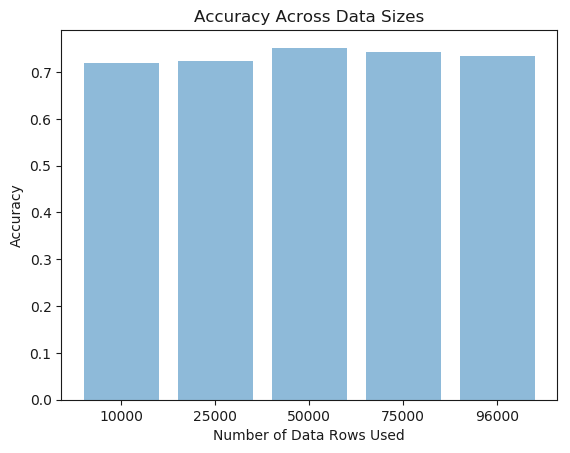

In [36]:


objects = []
performance = []
for each in acc_test:
    objects.append(each)
    performance.append(acc_test[each])
    
y_pos = np.arange(len(objects))
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.xlabel('Number of Data Rows Used')
plt.title('Accuracy Across Data Sizes')
 
plt.show()

In [37]:
# split into train & test
diag_pat_one_train,diag_pat_one_test = train_test_split(diag_pat_one, test_size=0.3)

In [38]:
# build a random forest
rf_model = skens.RandomForestClassifier(n_estimators=10,oob_score=True, criterion='entropy')
rf_model.fit(diag_pat_one_train.ix[:,1:],diag_pat_one_train.FIRST_ICD9_DIAGNOSIS)

C:\Users\julie\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\julie\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\julie\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [39]:
# now do the predicting... use the same approach as you did in testing the Decision Tree Classifier above,
# but don't include the .sample() line
# this is testing the model 
predicted_labels = rf_model.predict(diag_pat_one_test.ix[:,1:])
diag_pat_one_test['predicted_rf_tree'] = predicted_labels

C:\Users\julie\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
C:\Users\julie\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [41]:
diag_pat_one_test.head()

,FIRST_ICD9_DIAGNOSIS,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,LENGTHOFSTAY_DAYS,DIAGNOSIS,ICU_LOS,ITEMID2,VALUENUM2,predicted_rf_tree
40,41401,1.0,4,1,1,2,8,11,4.3483,27,0,41401
174,7863,0.0,1,1,2,2,7,26,6.7933,27,0,07020
3776,2766,1.0,4,2,6,1,2,98,1.8477,220045,102.0,2766
3327,40301,1.0,4,2,6,1,6,68,3.1842,220045,101.0,40301
2740,40301,1.0,4,2,6,1,5,68,1.3151,220045,101.0,40301


In [42]:
# Check feature importance
feat_importance = rf_model.feature_importances_
pd.DataFrame({'Feature Importance':feat_importance},
            index=diag_pat_one_train.columns[1:]).plot(kind='barh')

In [43]:

accuracy = accuracy_score(diag_pat_one_test.FIRST_ICD9_DIAGNOSIS, predicted_labels)
print("Accuracy: {0:.2%}".format(accuracy))

Accuracy: 75.80%


Accuracy for predicting first assigned ICD9 code is 3-4% using only Length of Stay in Days, Gender, Ethnicity, Marital Status, Religion, and Language. Length of Stay in Days is the most important feature in this analysis. 
Accuracy increased to 6-7% with the addition of (prelimiary) diagnosis. 
Accuracy jumped to 49.89% with the addition of ICU Length of Stay.
Up to 59.72% with addition of (one) ItemId and ValueNum

In [44]:
param_grid = {
                 'n_estimators': [5, 10, 15, 20, 25], # number of trees in the forest
                 'max_depth': [2, 5, 7, 9], # maximum depth of the tree
             }

In [45]:
grid_clf = GridSearchCV(rf_model, param_grid, cv=10)
grid_clf.fit(diag_pat_one_train.ix[:,1:],diag_pat_one_train.FIRST_ICD9_DIAGNOSIS)

C:\Users\julie\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\Users\julie\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\julie\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\julie\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newa

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 15, 20, 25], 'max_depth': [2, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [46]:
grid_clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [47]:
print(grid_clf.best_params_)

# accuracy of best model = 
grid_clf.best_score_

{'max_depth': 9, 'n_estimators': 25}


0.7398547629218283

In [ ]:
# need to also do this for second and third assigned ICD9 codes

In [54]:
# look at other data: 


In [ ]:
# loop to predict multiple times, see what is predicted the most?

In [ ]:
# need to incorporate initial diagnosis information!!!! (some sort of text analysis?)

In [31]:
serv = pd.read_csv('AD_SERV.csv')
print(len(serv))
serv.head()

0


,SUBJECT_ID,HADM_ID,ADMISSIONTYPE,CURR_SERVICE


In [ ]:
# something is wrong with the service file?? 
# or maybe need a different table since we are taking emergency people...